In [1]:
!pip install scikit-learn

You should consider upgrading via the '/lnet/aic/personal/kydliceh/Articles_Analysis/venv/bin/python3 -m pip install --upgrade pip' command.


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.toktok import ToktokTokenizer
from preprocess_utils import load_jsonb
from pathlib import Path
import functools

In [7]:
models_folder = Path("models") / "pickled_models"
utils_folder = Path("utils")

In [8]:
folder = Path("final_dataset")

trainP = folder / "train.jsonb"
devP =  folder /"dev.jsonb"
testP = folder /"test.jsonb"
toktok = ToktokTokenizer()
tokenizer = functools.partial(toktok.tokenize)
stop_words = []
with open(utils_folder / "stopwords.txt", "r") as f:
    for line in f:
        stop_words.append(line.strip())


# Fit just once
vectorizer = TfidfVectorizer(max_features=10000, tokenizer=tokenizer, stop_words=stop_words, lowercase=True, strip_accents="unicode")

vectorizer_name = "tfidf_vectorizer.pkl"



In [11]:

data_train = load_jsonb(trainP)
vectorizer.fit((x["content"] for x in data_train))
pickle.dump(vectorizer, open(models_folder / vectorizer_name , "wb"))

In [3]:
import pickle

In [1]:
MAX_TRAIN=100000
MAXTEST=10000

In [11]:
import itertools

vectorizer = pickle.load(open(models_folder / vectorizer_name, "rb"))
data_train = itertools.islice(load_jsonb(trainP), MAX_TRAIN)
data_dev = load_jsonb(devP)
data_test = itertools.islice(load_jsonb(testP), MAXTEST)

X_train = vectorizer.transform((x["content"] for x in data_train))

#X_dev = vectorizer.transform((x["content"] for x in data_dev))
X_test = vectorizer.transform((x["content"] for x in data_test))

/lnet/aic/personal/kydliceh/Articles_Analysis/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'ackoli', 'aniz', 'aspon', 'behem', 'blizko', 'bohuzel', 'cau', 'chces', 'chteji', 'chtit', 'chut', 'ctrnact', 'ctyri', 'dal', 'dale', 'dekovat', 'dekujeme', 'dekuji', 'devatenact', 'devet', 'dobry', 'dvanact', 'dve', 'hodne', 'ja', 'jedenact', 'jenz', 'jestlize', 'jim', 'kazdy', 'krome', 'kvuli', 'maji', 'malo', 'mam', 'mame', 'mas', 'mne', 'mozna', 'musi', 'nami', 'nase', 'necht', 'neco', 'nedela', 'nedelaji', 'nedelam', 'nedelame', 'nedelas', 'nedelate', 'nejak', 'nekde', 'nekdo', 'nemaji', 'nemame', 'nemate', 'nemel', 'nemu', 'nestaci', 'nevadi', 'ni', 'nim', 'osmnact', 'patnact', 'pet', 'porad', 'pozde', 'prede', 'prese', 'prosim', 'proste', 'rovne', 'sedmnact', 'sest', 'sestnact', 'smeji', 'smi', 'ste', 'svuj', 'ted', 'tisic', 'tisice', 'tob

In [52]:
data_test = itertools.islice(load_jsonb(trainP), MAX_TRAIN, MAXTEST + MAX_TRAIN)

In [53]:
X_test = vectorizer.transform((x["content"] for x in data_test))

  6%|▌         | 109999/1781963 [00:30<07:45, 3595.23it/s] 


In [14]:
import matplotlib.pyplot as plt
import numpy as np

def report_stats(y):
    uniq, counts = np.unique(y, return_counts=True)
    max_i = np.argmax(counts)
    print(f"Length: {len(y)}")
    print(f"Length Unique values: {len(uniq)}")
    print(uniq)
    print(f"Baseline with max class {uniq[max_i]}: {counts[max_i] / len(y)}")

def plot_distribution(y):
    un, counts = np.unique(y, return_counts=True)
    plt.bar(un, counts)
    plt.show()

In [79]:
from typing import List, Type
from models.dataset import Dataset
from models.baseline_models import Model
from sklearn.metrics import f1_score
import functools



def train_model(model: Model, dataset: Dataset, validate_dataset: Dataset | None=None, hyperparams: List[dict]=[], metric: Callable | None = functools.partial(f1_score, average="macro")):
    best_params = model.get_params()
    best_score = float("inf")
    if len(hyperparams) == 0:
        hyperparams = [{}]

    default_params = model.get_params()
    real_val_d = validate_dataset
    if real_val_d is None:
        print("No validation dataset using training dataset")
        real_val_d = dataset

    for params in hyperparams:
        # Reset to default params
        model.set_params(**default_params)
        model.set_params(**params)
        model.fit(dataset.X, dataset.y)
            
        score = test_model(model, real_val_d, show_stats=False,metric=metric)
        if score > best_score:
            best_score = score
            best_params = model.get_params()

    model.set_params(**best_params)
    return model

In [73]:
from typing import Callable, Any


def test_model(model: Model, dataset: Dataset, show_stats=True, metric: Callable[[np.ndarray, np.ndarray], Any] | None = None ):
    if show_stats:
        plot_distribution(dataset.y)
        report_stats(dataset.y)

    if metric is None:
        return model.score(dataset.X, dataset.y)

    return metric(dataset.y, model.predict(dataset.X))

In [19]:
%load_ext autoreload
%autoreload 2

In [105]:
# Server prediction
from models.dataset import ArticleTFIDFDataset, remove_y_None, select_col
from models.baseline_models import ServerModel

serverDatasetTrain = ArticleTFIDFDataset(X_train, trainP, filter=remove_y_None, transform_Y=select_col("server"))

serverDatasetDev = ArticleTFIDFDataset(X_dev, devP, filter=remove_y_None, transform_Y=select_col("server"))

serverDatasetTest = ArticleTFIDFDataset(X_test, testP, filter=remove_y_None, transform_Y=select_col("server"))


100%|██████████| 222876/222876 [00:23<00:00, 9417.27it/s] 


In [106]:
model_file = models_folder / "server_model.pkl"
model = ServerModel()

In [ ]:
import itertools
# Get dictionary of potential hyperparameters and return a list of dictionaries with all possible combinations
def create_hyperparams(**kwargs):
    keys = kwargs.keys()
    values = kwargs.values()
    hyperparams = []
    for v in itertools.product(*values):
        hyperparams.append(dict(zip(keys, v)))
    return hyperparams


100%|██████████| 1783007/1783007 [01:42<00:00, 17341.43it/s]


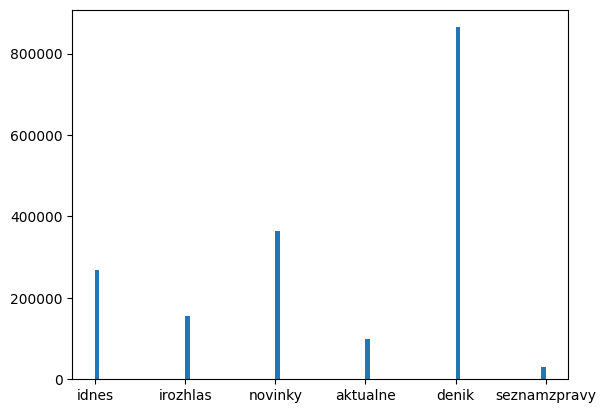

Unique values: 6


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        90006     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19472D+06    |proj g|=  5.67489D+05


 This problem is unconstrained.



At iterate   50    f=  1.33081D+06    |proj g|=  9.55481D+03

At iterate  100    f=  1.17999D+06    |proj g|=  3.16247D+03

At iterate  150    f=  1.13288D+06    |proj g|=  3.48766D+03

At iterate  200    f=  1.11292D+06    |proj g|=  3.75101D+03

At iterate  250    f=  1.10359D+06    |proj g|=  6.66007D+02

At iterate  300    f=  1.09901D+06    |proj g|=  1.30925D+03

At iterate  350    f=  1.09698D+06    |proj g|=  2.38931D+03

At iterate  400    f=  1.09575D+06    |proj g|=  5.72603D+02

At iterate  450    f=  1.09490D+06    |proj g|=  5.86979D+02

At iterate  500    f=  1.09454D+06    |proj g|=  5.75044D+02

At iterate  550    f=  1.09437D+06    |proj g|=  1.76281D+02

At iterate  600    f=  1.09424D+06    |proj g|=  2.33681D+02

At iterate  650    f=  1.09416D+06    |proj g|=  1.97602D+02

At iterate  700    f=  1.09412D+06    |proj g|=  1.00238D+02

At iterate  750    f=  1.09409D+06    |proj g|=  1.00949D+02

At iterate  800    f=  1.09408D+06    |proj g|=  2.70417D+01

At iter

/lnet/aic/personal/kydliceh/Articles_Analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed: 103.7min finished


0.7923608824867204


100%|██████████| 222876/222876 [00:16<00:00, 13634.84it/s]


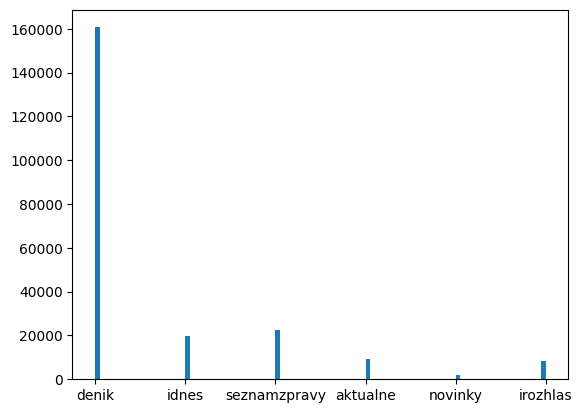

Unique values: 6
0.6758511459286778


In [12]:
# Training
hyperparams = create_hyperparams(
    C=[0.1, 1]
)

model = train_model(model, serverDatasetTrain, serverDatasetDev)
model.save(model_file)

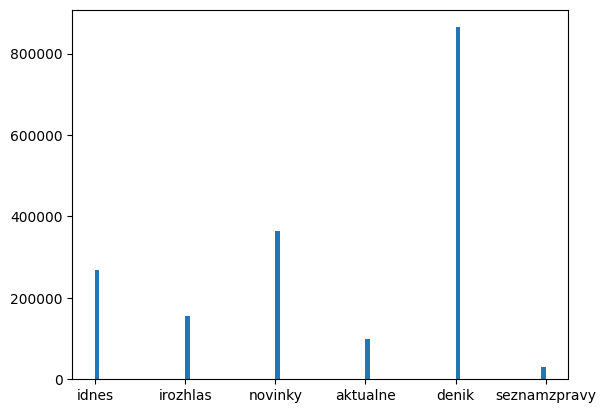

Unique values: 6
Length: 1783007
              precision    recall  f1-score   support

    aktualne       0.74      0.66      0.70     99671
       denik       0.84      0.92      0.88    864657
       idnes       0.71      0.57      0.63    268150
    irozhlas       0.74      0.66      0.70    154710
     novinky       0.76      0.78      0.77    364876
seznamzpravy       0.74      0.44      0.55     30943

    accuracy                           0.79   1783007
   macro avg       0.75      0.67      0.70   1783007
weighted avg       0.79      0.79      0.79   1783007



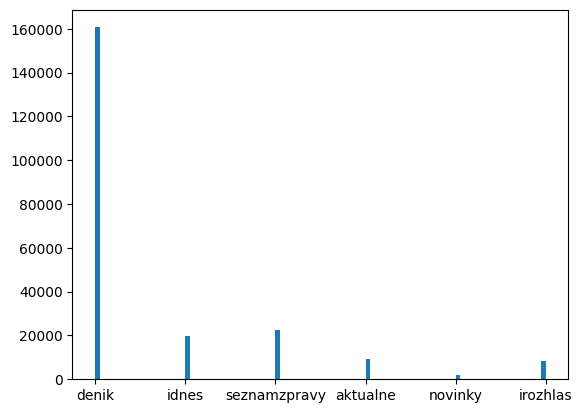

Unique values: 6
Length: 222876
              precision    recall  f1-score   support

    aktualne       0.43      0.53      0.47      9340
       denik       0.86      0.80      0.83    160723
       idnes       0.28      0.38      0.32     19934
    irozhlas       0.30      0.44      0.36      8131
     novinky       0.07      0.51      0.12      2086
seznamzpravy       0.69      0.23      0.34     22662

    accuracy                           0.68    222876
   macro avg       0.44      0.48      0.41    222876
weighted avg       0.74      0.68      0.69    222876



In [107]:
model.load(model_file)
test_model(model, serverDatasetTrain)
test_model(model, serverDatasetTest)

In [31]:
cats = list(filter(lambda x: x is not None,  map(lambda x: x["category"], itertools.islice(load_jsonb(trainP), MAX_TRAIN))))

  6%|▌         | 99999/1781963 [00:07<01:58, 14157.51it/s]


In [54]:
from models.dataset import get_top_unique
unique = get_top_unique(cats, 50)

In [55]:
with open(utils_folder / "categories.txt", "w") as f:
    for cat in unique:
        f.write(cat + "\n")

In [57]:
unique = set(unique)

In [59]:
# Category prediction
from models.dataset import ArticleTFIDFDataset, remove_y_None, select_col, sequence_transform, filter_by_set, sequence_filter

categoryDatasetTrain = ArticleTFIDFDataset(X_train, trainP, filter=sequence_filter([filter_by_set(unique), remove_y_None]), transform_Y=select_col("category"), start=0, end=MAX_TRAIN)

categoryDatasetTest = ArticleTFIDFDataset(X_test, trainP, filter=sequence_filter([filter_by_set(unique), remove_y_None]),transform_Y=select_col("category"), start=MAX_TRAIN, end=MAX_TRAIN + MAXTEST)


  6%|▌         | 109999/1781963 [00:07<01:55, 14534.41it/s]


In [60]:
len(categoryDatasetTrain.y), len(categoryDatasetTest.y)

(93063, 9434)

In [83]:
from models.baseline_models import CategoryModel
model_file = models_folder / "category_model.pkl"
model = CategoryModel()

In [84]:
# Training
model = train_model(model, categoryDatasetTrain)
model.save(model_file)

No validation dataset using training dataset


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       500050     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64065D+05    |proj g|=  8.26074D+03


 This problem is unconstrained.



At iterate   50    f=  1.10765D+05    |proj g|=  4.51526D+02

At iterate  100    f=  9.93434D+04    |proj g|=  1.58475D+02

At iterate  150    f=  9.82283D+04    |proj g|=  4.13718D+01

At iterate  200    f=  9.81239D+04    |proj g|=  1.86685D+01

At iterate  250    f=  9.81135D+04    |proj g|=  3.47524D+00

At iterate  300    f=  9.81127D+04    |proj g|=  2.03546D+00

At iterate  350    f=  9.81126D+04    |proj g|=  5.86988D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    353    369      1     0     0   3.314D-01   9.811D+04
  F =   98112.598192028468     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed: 10.3min finished


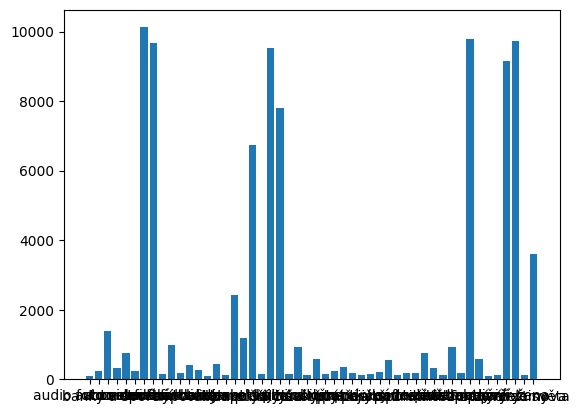

Length: 93063
Length Unique values: 50
['audio foto video' 'auto' 'automoto' 'banky a spoření' 'bonusweb'
 'cestování' 'domácí' 'ekonomika' 'film a tv' 'finance' 'fotbal'
 'hardware' 'hokej' 'hudba' 'hypotéky a půjčky' 'internet' 'internet a pc'
 'irák po válce' 'koktejl' 'komerční články' 'krimi' 'kultura' 'lyže'
 'mobil' 'návštěvy' 'odložna' 'ona' 'ostatní' 'plné hry' 'po česku'
 'podniky' 'pojištění' 'práce a podnikání' 'revue' 'rádce' 'software'
 'společnost' 'sport' 'svět' 'tech & trendy' 'technet' 'věda & vesmír'
 'zahraniční' 'zahraničí' 'zdraví' 'zprávy' 'zprávy z domova'
 'zprávy ze světa' 'češtiny' 'žena']
Baseline with max class domácí: 0.10876503014087231


/lnet/aic/personal/kydliceh/Articles_Analysis/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lnet/aic/personal/kydliceh/Articles_Analysis/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lnet/aic/personal/kydliceh/Articles_Analysis/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

                   precision    recall  f1-score   support

 audio foto video       1.00      0.21      0.34        96
             auto       0.74      0.28      0.41       239
         automoto       0.85      0.84      0.85      1381
  banky a spoření       0.70      0.42      0.52       324
         bonusweb       0.86      0.85      0.86       761
        cestování       0.84      0.13      0.23       234
           domácí       0.78      0.78      0.78     10122
        ekonomika       0.77      0.86      0.81      9672
        film a tv       0.00      0.00      0.00       165
          finance       0.60      0.63      0.61       974
           fotbal       1.00      0.31      0.47       168
         hardware       0.79      0.70      0.74       400
            hokej       0.91      0.62      0.73       268
            hudba       0.00      0.00      0.00       102
hypotéky a půjčky       0.67      0.46      0.55       441
         internet       0.00      0.00      0.00       

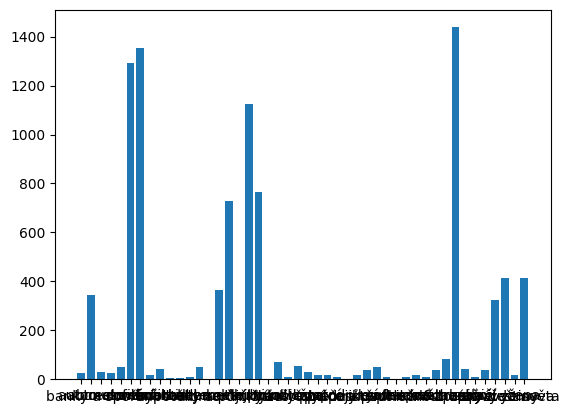

Length: 9434
Length Unique values: 46
['auto' 'automoto' 'banky a spoření' 'bonusweb' 'cestování' 'domácí'
 'ekonomika' 'film a tv' 'finance' 'fotbal' 'hokej' 'hudba'
 'hypotéky a půjčky' 'internet' 'internet a pc' 'koktejl'
 'komerční články' 'krimi' 'kultura' 'lyže' 'mobil' 'návštěvy' 'odložna'
 'ona' 'ostatní' 'plné hry' 'po česku' 'podniky' 'pojištění'
 'práce a podnikání' 'revue' 'rádce' 'software' 'společnost' 'sport'
 'svět' 'tech & trendy' 'technet' 'zahraniční' 'zahraničí' 'zdraví'
 'zprávy' 'zprávy z domova' 'zprávy ze světa' 'češtiny' 'žena']
Baseline with max class zahraniční: 0.15242739029043884
                   precision    recall  f1-score   support

             auto       0.67      0.15      0.24        27
         automoto       0.85      0.76      0.80       346
  banky a spoření       0.77      0.33      0.47        30
         bonusweb       0.39      0.48      0.43        25
        cestování       1.00      0.08      0.15        49
           domácí       0.72 

/lnet/aic/personal/kydliceh/Articles_Analysis/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lnet/aic/personal/kydliceh/Articles_Analysis/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lnet/aic/personal/kydliceh/Articles_Analysis/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

In [85]:

model.load(model_file)
print(test_model(model, categoryDatasetTrain))
print(test_model(model, categoryDatasetTest))

In [87]:
# Gender prediction
from models.baseline_models import AuthorGenderModel
from models.dataset import sequence_transform, gender_type_transform

from models.baseline_models import DayModel
genderDatasetTrain = ArticleTFIDFDataset(X_train, trainP, filter=remove_y_None, transform_Y=sequence_transform([select_col("author_genders"), gender_type_transform]), end=MAX_TRAIN)

genderDatasetTest = ArticleTFIDFDataset(X_test, trainP, filter=remove_y_None, transform_Y=sequence_transform([select_col("author_genders"), gender_type_transform]), start=MAX_TRAIN, end=MAX_TRAIN + MAXTEST)


  6%|▌         | 109999/1781963 [00:09<02:26, 11419.44it/s]


In [96]:
from models.baseline_models import AuthorGenderModelSimple
model = AuthorGenderModelSimple()
model_file = models_folder / "author_gender_model.pkl"

In [97]:
model = train_model(model, genderDatasetTrain)
model.save(model_file)

No validation dataset using training dataset


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
3936.48s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3936.46s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3936.54s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3936.62s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3936.70s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3936.71s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3936.74s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3936.80s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        30003     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.43560D+04    |proj g|=  1.18127D+04


 This problem is unconstrained.



At iterate   50    f=  3.36563D+04    |proj g|=  1.89643D+02

At iterate  100    f=  3.29074D+04    |proj g|=  9.16681D+01

At iterate  150    f=  3.28782D+04    |proj g|=  1.23916D+01

At iterate  200    f=  3.28764D+04    |proj g|=  1.41632D+00

At iterate  250    f=  3.28762D+04    |proj g|=  6.19838D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
30003    270    311      1     0     0   2.084D-01   3.288D+04
  F =   32876.211754254575     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:   39.7s finished


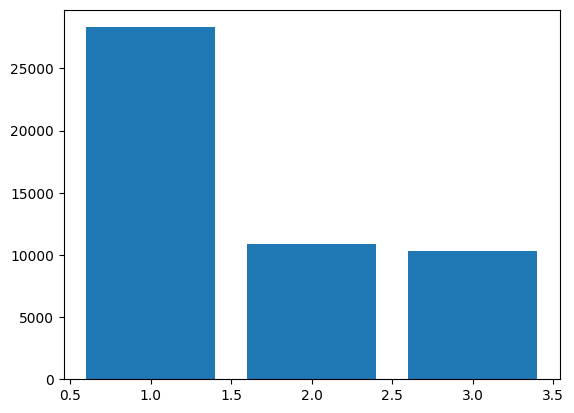

Length: 49477
Length Unique values: 3
[1 2 3]
Baseline with max class 1: 0.572083998625624
              precision    recall  f1-score   support

           1       0.78      0.91      0.84     28305
           2       0.75      0.44      0.56     10879
           3       0.68      0.65      0.66     10293

    accuracy                           0.75     49477
   macro avg       0.73      0.67      0.69     49477
weighted avg       0.75      0.75      0.74     49477



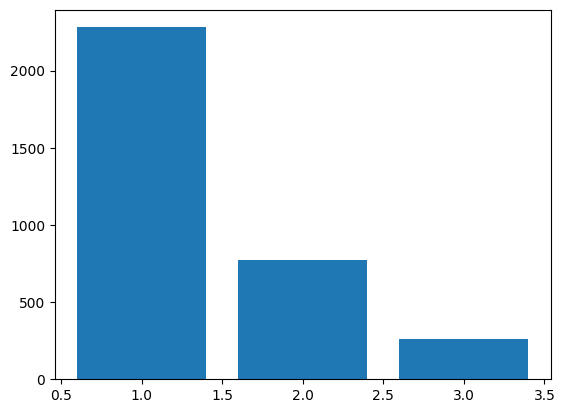

Length: 3314
Length Unique values: 3
[1 2 3]
Baseline with max class 1: 0.6882920941460471
              precision    recall  f1-score   support

           1       0.77      0.86      0.81      2281
           2       0.58      0.32      0.41       772
           3       0.34      0.44      0.39       261

    accuracy                           0.70      3314
   macro avg       0.56      0.54      0.53      3314
weighted avg       0.69      0.70      0.68      3314



In [102]:
model.load(model_file)
print(test_model(model, genderDatasetTrain))
print(test_model(model, genderDatasetTest))

In [76]:
# Day prediction
from models.dataset import ArticleTFIDFDataset, remove_y_None, select_col
from models.baseline_models import DayModel

dateDatasetTrain = ArticleTFIDFDataset(X_train, trainP, filter=remove_y_None, transform_Y=select_col("day"))

dateDatasetTest = ArticleTFIDFDataset(X_test, testP, filter=remove_y_None, transform_Y=select_col("day"))

In [ ]:
day_model_file = models_folder / "day_model.pkl"
day_model = DayModel()

100%|██████████| 1783007/1783007 [03:19<00:00, 8939.23it/s] 


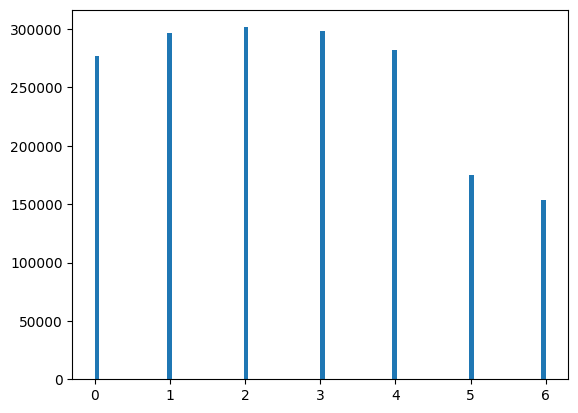

Unique values: 6


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       105007     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46957D+06    |proj g|=  1.01382D+05


 This problem is unconstrained.



At iterate   50    f=  3.28665D+06    |proj g|=  3.88254D+03

At iterate  100    f=  3.24127D+06    |proj g|=  4.31174D+03

At iterate  150    f=  3.20629D+06    |proj g|=  8.61626D+02

At iterate  200    f=  3.19545D+06    |proj g|=  8.84008D+03

At iterate  250    f=  3.18933D+06    |proj g|=  4.98023D+03

At iterate  300    f=  3.18625D+06    |proj g|=  1.52871D+03

At iterate  350    f=  3.18493D+06    |proj g|=  8.82482D+02

At iterate  400    f=  3.18427D+06    |proj g|=  1.24268D+03

At iterate  450    f=  3.18389D+06    |proj g|=  8.24275D+02

At iterate  500    f=  3.18362D+06    |proj g|=  4.61937D+02

At iterate  550    f=  3.18341D+06    |proj g|=  8.99311D+02

At iterate  600    f=  3.18331D+06    |proj g|=  9.76963D+01

At iterate  650    f=  3.18326D+06    |proj g|=  4.30613D+02

At iterate  700    f=  3.18323D+06    |proj g|=  9.41131D+01

At iterate  750    f=  3.18322D+06    |proj g|=  2.26700D+02

At iterate  800    f=  3.18321D+06    |proj g|=  1.55707D+02

At iter

[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed: 115.9min finished


              precision    recall  f1-score   support

           0       0.29      0.30      0.29    277087
           1       0.29      0.31      0.30    296637
           2       0.29      0.33      0.31    301446
           3       0.28      0.32      0.30    298062
           4       0.29      0.29      0.29    281756
           5       0.33      0.20      0.25    174686
           6       0.34      0.21      0.26    153333

    accuracy                           0.29   1783007
   macro avg       0.30      0.28      0.29   1783007
weighted avg       0.30      0.29      0.29   1783007



100%|██████████| 222876/222876 [00:31<00:00, 7085.75it/s]


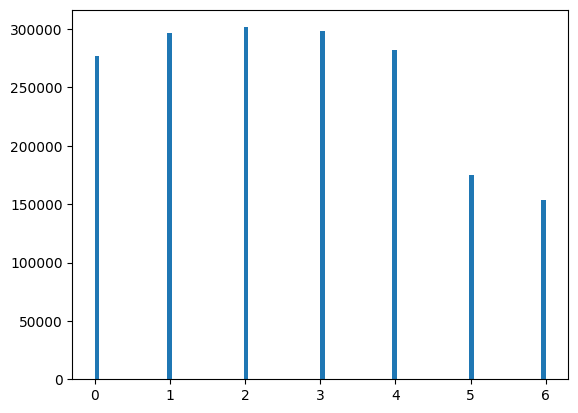

Unique values: 6
              precision    recall  f1-score   support

           0       0.17      0.19      0.18     35348
           1       0.16      0.18      0.17     35966
           2       0.15      0.16      0.16     35497
           3       0.14      0.19      0.16     33995
           4       0.14      0.14      0.14     33831
           5       0.11      0.06      0.08     25652
           6       0.09      0.05      0.06     22587

    accuracy                           0.15    222876
   macro avg       0.14      0.14      0.14    222876
weighted avg       0.14      0.15      0.14    222876



In [54]:
# Training
day_model = train_model(day_model, dateDatasetTrain)
day_model.save(day_model_file)

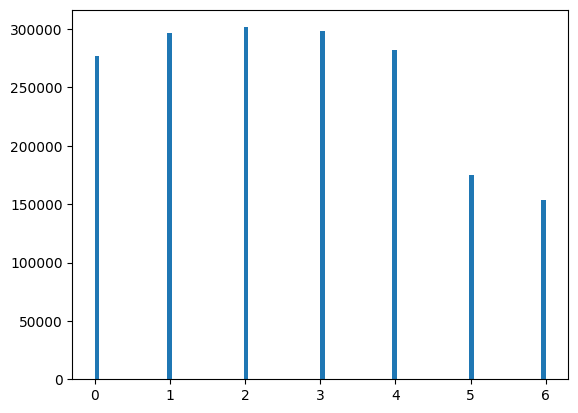

Unique values: 7
Length: 1783007
              precision    recall  f1-score   support

           0       0.29      0.30      0.29    277087
           1       0.29      0.31      0.30    296637
           2       0.29      0.33      0.31    301446
           3       0.28      0.32      0.30    298062
           4       0.29      0.29      0.29    281756
           5       0.33      0.20      0.25    174686
           6       0.34      0.21      0.26    153333

    accuracy                           0.29   1783007
   macro avg       0.30      0.28      0.29   1783007
weighted avg       0.30      0.29      0.29   1783007



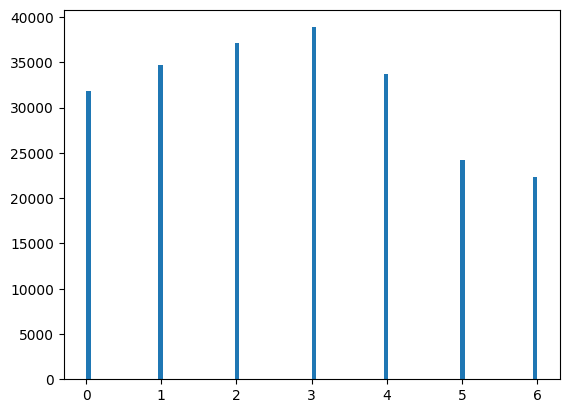

Unique values: 7
Length: 222876
              precision    recall  f1-score   support

           0       0.18      0.22      0.20     31842
           1       0.19      0.23      0.21     34731
           2       0.20      0.20      0.20     37104
           3       0.22      0.25      0.23     38875
           4       0.19      0.19      0.19     33745
           5       0.18      0.11      0.14     24196
           6       0.22      0.13      0.16     22383

    accuracy                           0.20    222876
   macro avg       0.20      0.19      0.19    222876
weighted avg       0.20      0.20      0.19    222876



In [82]:
day_model.load(day_model_file)
test_model(day_model, dateDatasetTrain)
test_model(day_model, dateDatasetTest)